In [3]:
!pip install wordcloud
!pip install beautifulsoup4
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 8.1 MB/s eta 0:00:00a 0:00:01


In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import wordcloud
import requests
import re
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import time
import json

In [148]:
URL_FILENAME = 'indexed_data.json'

In [147]:
def extract_data(start):
    try :
        if not os.path.exists(URL_FILENAME):
            raise FileNotFoundError()
    except :
        youtube_url = 'https://www.youtube.com/@ITSUB/videos'
        driver = webdriver.Chrome()
        driver.get(youtube_url)
        
        driver.maximize_window()
        time.sleep(3)
    
        # 무한 스크롤
        last_height = driver.execute_script("return document.getElementById('content').scrollHeight") 
        while True :
            body = driver.find_element(By.TAG_NAME, 'body')
            body.send_keys(Keys.END)
            time.sleep(2)
    
            current_height = driver.execute_script("return document.getElementById('content').scrollHeight")
            if current_height == last_height:
                break 
    
            last_height = current_height
    
        video_elements = driver.find_elements(By.ID, "video-title-link")
        video_urls = {}
        for i in range(len(video_elements)):
            url = video_elements[i].get_attribute("href")
            if url:
                video_urls[i] = url
                
        print(f"총 {len(video_urls)}개의 영상 URL을 수집했습니다.")
    
        with open(URL_FILENAME, "w", encoding="utf-8") as f:
            json.dump(video_urls, f, ensure_ascii=False, indent=4)

        driver.quit()
        
    finally : 
        
        with open(URL_FILENAME, "r", encoding="utf-8") as f:
            video_urls = json.load(f)
            video_urls_list = list(video_urls.values())

        driver = webdriver.Chrome()
        driver.maximize_window()

        video_info_lists = []
        try :
            i=0
            for url in video_urls_list[start:]:
                driver.get(url)
                
                time.sleep(1.5)
    
                #좋아요 수
                element = driver.find_element(By.CSS_SELECTOR, "#top-level-buttons-computed > segmented-like-dislike-button-view-model > yt-smartimation > div > div > like-button-view-model > toggle-button-view-model > button-view-model > button")
                like = element.get_attribute("aria-label")
                like = ''.join(re.findall(r'\d+', like))
                
                more_button = driver.find_element(By.ID, "expand")
                if more_button:
                    more_button.click()
    
                #제목
                title = driver.find_element(By.CSS_SELECTOR, "#title > h1 > yt-formatted-string").text
                #조회수
                view = driver.find_element(By.CSS_SELECTOR, "#info > span:nth-child(1)").text
                view = ''.join(re.findall(r'\d+', view))
                
                #댓글 수
                driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
                time.sleep(3)
    
                try :
                    comments_section = driver.find_element(By.CSS_SELECTOR, "#count > yt-formatted-string > span:nth-child(2)")
                except :
                    comments = 0
                    
                if comments_section :
                    comments = comments_section.text
    
                video_info_lists.append(
                    {
                        "title" : title,
                        "view" : view, 
                        "comments" : comments,
                        "like" : like,
                        "url" : url
                    }
                )
                i += 1
                print(f"\r[{i}/{len(video_urls_list[start:])}] Fetched: {title}", end='')
                
        except Exception as e:
            print(e)
            
        finally :
            df = pd.DataFrame(video_info_lists, columns = ["title", "view", "comments", "like","url"])
            df.to_json('itsub_video_info_({start}~{end}).json'.format(start = start, end = start + len(video_info_lists)-1), orient = 'index', indent = 4)
            driver.quit()
             
    
extract_data(982)

Message: stale element reference: stale element not found오미 주전자&다이슨 거치대&철제 선반+ Unboxing)LG OLED65C8P)use) Pro 2018)e)
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#stale-element-reference-exception
Stacktrace:
0   chromedriver                        0x0000000102fd6138 cxxbridge1$str$ptr + 3653888
1   chromedriver                        0x0000000102fce988 cxxbridge1$str$ptr + 3623248
2   chromedriver                        0x0000000102a34968 cxxbridge1$string$len + 89228
3   chromedriver                        0x0000000102a438e0 cxxbridge1$string$len + 150532
4   chromedriver                        0x0000000102a429f0 cxxbridge1$string$len + 146708
5   chromedriver                        0x0000000102a3a138 cxxbridge1$string$len + 111708
6   chromedriver                        0x0000000102a38a08 cxxbridge1$string$len + 105772
7   chromedriver                        0x000000010

In [93]:
def transform(df) :
    df['comments'] = df['comments'].str.replace(',', '').astype(int)
    df['view'] = df['view'].astype(int)
    df['like'] = df['like'].astype(int)
    
    stats = df.describe()
    stats_75 = stats.loc["75%"]
    stats_25 = stats.loc["25%"]
    
    # 조회수, 좋아요
    # 분포 75% 이상
    # 분포 25% 이하 
    # 선호 컨텐츠 : 1
    # 비선호 컨텐츠 : 0
    df['prefer'] = df.apply(lambda row : labeling(row, stats_75, stats_25), axis=1)

    # 타이틀을 다듬어 주기
    # 
    
    return df

def labeling(row, stats_75, stats_25):
     if (row["view"] >= stats_75["view"] and
        row["like"] >= stats_75["like"]):
        return 1
     elif (row["view"] <= stats_25["view"] and
          row["like"] <= stats_25["like"]):
        return -1
     else:
        return 0

def corr_df(df):
    numeric_df = df.drop(columns=["title", "url"]) 
    numeric_df['comments'] = numeric_df['comments'].str.replace(',', '').astype(int)
    return numeric_df.corr(method = 'kendall')
         

In [111]:
def display(df) :
    # word_cloud 활용해서 데이터 보여주기
    df_prefer = df[df['prefer'] == 1]
    df_non_prefer = df[df['prefer'] == -1]

    df_prefer['title'] = df_prefer['title'].apply(lambda s : re.sub("[^가-힣 ]","",s))
    df_non_prefer['title'] = df_non_prefer['title'].apply(lambda s : re.sub("[^가-힣] ","",s))

    prefer_text = " ".join(df_prefer["title"])
    non_prefer_text = " ".join(df_non_prefer["title"])

    word_cloud_prefer = wordcloud.WordCloud(max_words = 200, font_path="/System/Library/Fonts/AppleSDGothicNeo.ttc", colormap = "Blues")
    words_prefer = word_cloud_prefer.generate(prefer_text)

    word_cloud_non_prefer = wordcloud.WordCloud(max_words = 200, font_path="/System/Library/Fonts/AppleSDGothicNeo.ttc",  colormap = "Reds")   
    words_non_prefer = word_cloud_non_prefer.generate(non_prefer_text)

    plt.figure(figsize = (14,7))
    plt.subplot(2,1,1)
    plt.imshow(words_prefer)
    plt.axis("off")
    plt.title("Prefer Contents")
    
    plt.figure(figsize = (14,7))
    plt.subplot(2,1,1)
    plt.imshow(words_non_prefer)
    plt.axis("off")
    plt.title("Non - Prefer Contents")

    
    plt.tight_layout()
    plt.show()
    

               view      comments          like
count  2.140000e+02    214.000000    214.000000
mean   8.367577e+05   1309.434579   8362.411215
std    4.110129e+05   1638.516724   4508.961679
min    2.249410e+05    349.000000   2617.000000
25%    5.718288e+05    785.250000   5822.750000
50%    7.427635e+05   1031.000000   7686.500000
75%    9.840632e+05   1445.250000   9666.000000
max    2.465849e+06  22850.000000  52741.000000


/var/folders/cw/5cxz2ybs5ls_6q0108849sb40000gn/T/ipykernel_2944/2578594978.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prefer['title'] = df_prefer['title'].apply(lambda s : re.sub("[^가-힣 ]","",s))
/var/folders/cw/5cxz2ybs5ls_6q0108849sb40000gn/T/ipykernel_2944/2578594978.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_prefer['title'] = df_non_prefer['title'].apply(lambda s : re.sub("[^가-힣] ","",s))


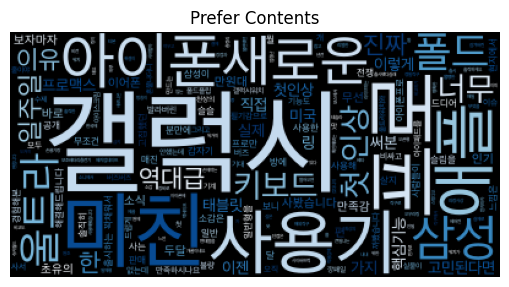

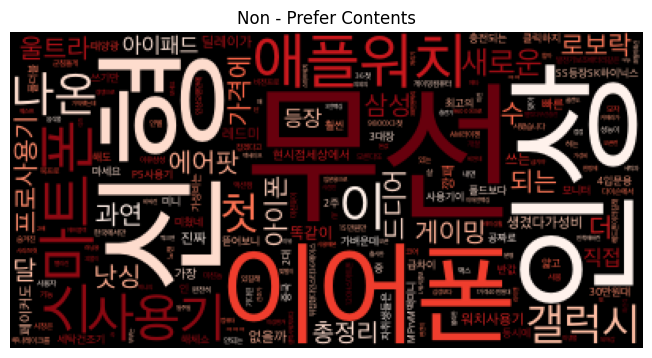

In [112]:
def ETL():
    # extract_data()
    
    with open('itsub_video_info(10 ~ 223).json', 'r') as file:
        json_data = json.load(file)
    df_video_list = pd.DataFrame.from_dict(json_data, orient = 'index')
    print(corr_df(df_video_list))
    
    transformed_data = transform(df_video_list)
    display(transformed_data)
    
ETL()